# GLM(一般化線形モデル)の実装例

- ここでは、GLMの一つであるロジスティック回帰モデルの実装例を紹介する
- モデルの定義とパラメータの推論を実装する

## ライブラリのimport

In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
c_list = sns.color_palette().as_hex()
color_num = len(c_list)

描画関連のライブラリは、`matplotlib`だけが必須で`seaborn`は特に必要ではない。

`seaborn`については、下記ページなどを参照。

- [seabornを利用したデータ可視化（data visualization）の基礎: あつまれ統計の森](https://www.hello-statisticians.com/python/data-vis-seaborn-01.html)

## 問題設定1: トイデータ

一つ目の問題設定として、正解モデルがわかっているという仮定でトイデータを作成し、
勾配法によってパラメータの推論が想定通りにできるのかを確認する。

### 真のモデル設定

実際の問題では観測されない、真のモデル。今回はトイデータを生成するために、データの生成モデルを以下のように設定。

- 目的変数$y_i$のモデル: $y_i \sim \mathrm{Bern}\left( y_i | p_i \right)$
- $y_i$の生起確率: $p_i = \mathrm{Sigmoid}(r_i) = \frac{\exp(r_i)}{1 + \exp(r_i)} = \frac{1}{1 + \exp(-r_i)}$
- 線形予測子: $r_i = \beta_0 + \beta_1 x$


In [3]:
def linear_predictor(x, b0=1.0, b1=2.0):
    return (b0 + b1*x)

def prob(r):
    return (1. / (1. + np.exp(-1. * r)))

def sample(x):
    r = linear_predictor(x)
    p = prob(r)
    y = scipy.stats.bernoulli(p=p).rvs()
    return y

モデル設定を確認する

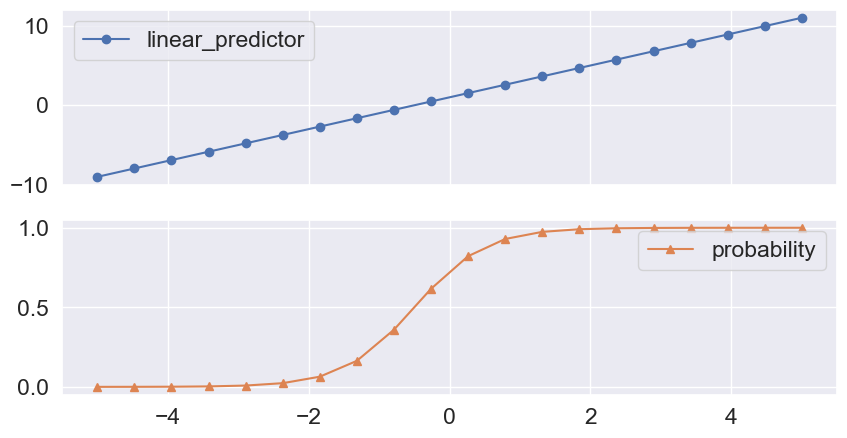

In [4]:
xs_set = np.linspace(-5, 5, 20)
rs_set = linear_predictor(xs_set)
ps_set = prob(rs_set)

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axs[0].plot(xs_set, rs_set, "-o", color=c_list[0], label="linear_predictor")
axs[0].legend();
axs[1].plot(xs_set, ps_set, "-^", color=c_list[1], label="probability")
axs[1].legend();

真のモデルからデータを生成する。
このデータを利用してモデルのパラメータ($\beta_0, \beta_1$)を推定する。

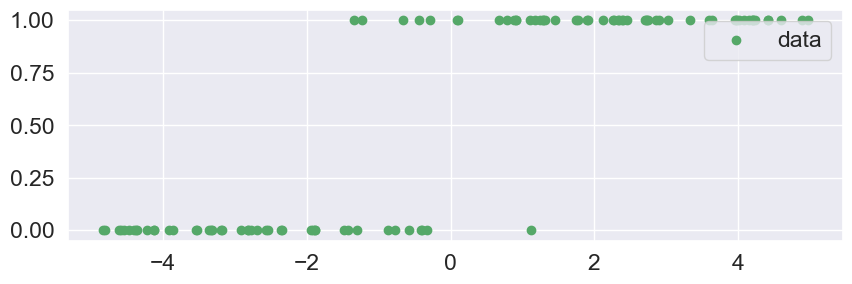

In [5]:
X = np.random.uniform(low=-5, high=5, size=100)
Y = sample(X)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.scatter(X, Y, color=c_list[2], label="data")
ax.legend();

In [6]:
pd.DataFrame({
    "x": X, "y": Y
}).head(n=10)

,x,y
0,3.600517,1
1,1.456812,1
2,-1.345468,1
3,4.971737,1
4,4.010470,1
5,-0.392284,0
6,2.128578,1
7,2.351752,1
8,-3.925091,0
9,-1.889087,0


### モデル設計(データをフィッティングするモデル)

1次の線形予測子によるロジスティック回帰モデルを仮定する(真のモデルと同じ)。

- 目的変数$y_i$のモデル: $y_i \sim \mathrm{Bern}\left( y_i | p_i \right)$
- $y_i$の生起確率: $p_i = \mathrm{Sigmoid}(r_i) = \frac{1}{1 + \exp(-r_i)}$
- 線形予測子: $r_i = \beta_0 + \beta_1 x$

このモデルにおける未知のパラメータは線形予測子の係数($\beta_0, \beta_1$)の二つ。

### パラメータ推定(勾配法)

対数尤度関数($\log L(\beta_0, \beta_1)$)の勾配は下記の通り

$$
\begin{align}
\frac{\partial \log{L(\beta_0,\beta_1)}}{\partial \beta_0} &= \sum_{i=1}^{n} (y_i - p_i) \\
\frac{\partial \log{L(\beta_0,\beta_1)}}{\partial \beta_1} &= \sum_{i=1}^{n} (y_i - p_i) x_i
\end{align}
$$

勾配の導出にあたっては下記を参照

- [最尤法とGLM(Generalized Linear Model)｜問題演習で理解する統計学【7】: あつまれ統計の森](https://www.hello-statisticians.com/practice/stat_practice7.html)
- [【統計の森ちゃんねる】演習で理解する統計学シリーズ: YouTube](https://youtube.com/playlist?list=PL43evawK_NGSsD6SRozDRBTJjzLgDULv9)

In [7]:
# 初期値
b0, b1 = 0.0, 1.0

# 学習係数
alpha = 0.1

epoch = 30  # 繰り返し回数(epoch数)
trace = [[b0, b1]]
for i in range(epoch):
    rs = linear_predictor(X, b0=b0, b1=b1)
    ps = prob(rs)
    b0 = b0 + alpha * np.sum(Y - ps)
    b1 = b1 + alpha * np.sum((Y - ps)*X)
    trace.append([b0, b1])
trace = np.array(trace)

print(f"(b0, b1) = ({b0: 2.3}, {b1: 2.3})")

(b0, b1) = ( 0.846,  1.89)


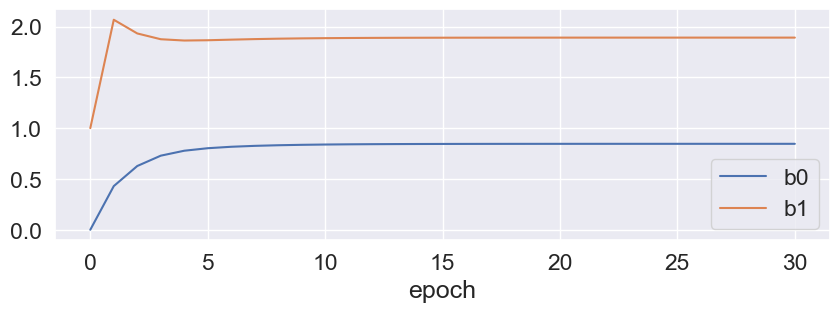

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10, 3))
ax.plot(trace[:, 0], label="b0")
ax.plot(trace[:, 1], label="b1")
ax.legend();
ax.set_xlabel("epoch");

学習結果の確認

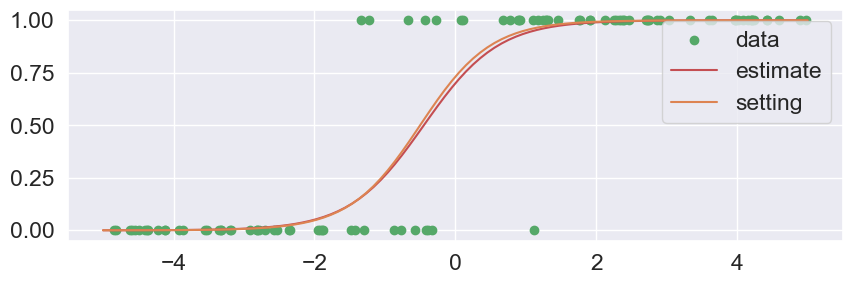

In [9]:
xs = np.linspace(-5, 5, 100)
rs = linear_predictor(xs, b0=b0, b1=b1)
ps = prob(rs)
rs_set = linear_predictor(xs)
ps_set = prob(rs_set)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.scatter(X, Y, color=c_list[2], label="data")
ax.plot(xs, ps, color=c_list[3], label="estimate")
ax.plot(xs, ps_set, color=c_list[1], label="setting")
ax.legend();

## 問題設定2: アヤメデータセット(単変量)

分類問題の例

### データを確認する

In [10]:
df_iris = sns.load_dataset("iris")
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [11]:
target = ["versicolor", "virginica"]
df = df_iris[[s in target for s in df_iris.species]]

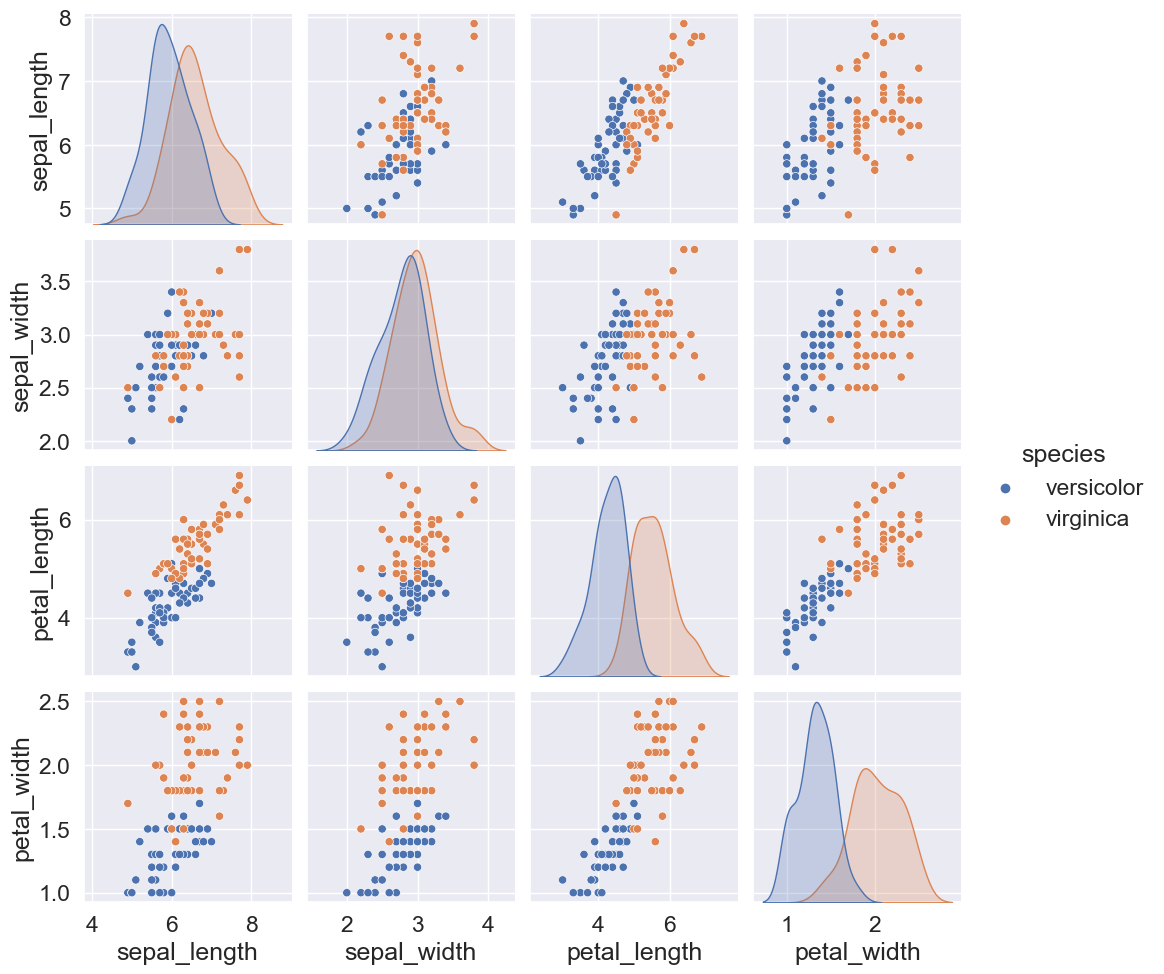

In [12]:
sns.pairplot(df, hue="species");

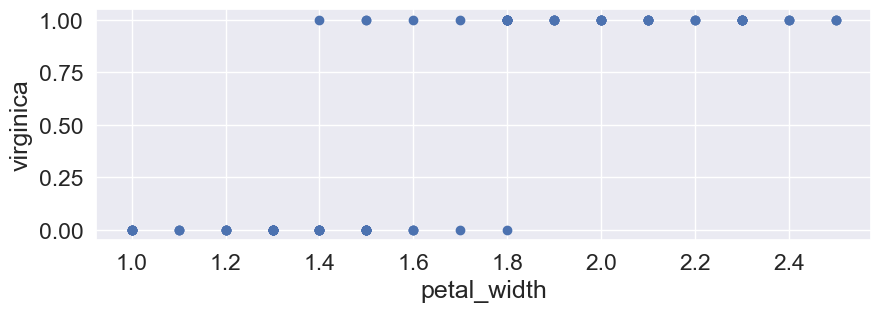

In [13]:
Y = [s == "virginica" for s in df.species]
X = df.petal_width.values

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.scatter(X, Y)
ax.set_xlabel("petal_width");
ax.set_ylabel("virginica");

### モデル設計

1次の線形予測子によるロジスティック回帰モデルを仮定する。

- 目的変数$y_i$: virginicaであるか否か
    - $y_i \sim \mathrm{Bern}\left( y_i | p_i \right)$
- $y_i$の生起確率: $p_i = \mathrm{Sigmoid}(r_i) = \frac{1}{1 + \exp(-r_i)}$
- 線形予測子: $r_i = \beta_0 + \beta_1 x$
    - 説明変数$x_i$は１種類(petal_length)

このモデルにおける未知のパラメータは線形予測子の係数($\beta_0, \beta_1$)の二つ。

In [14]:
def linear_predictor(x, b0, b1):
    return (b0 + b1*x)

def prob(r):
    return (1. / (1. + np.exp(-1. * r)))

### パラメータ推定(勾配法)

In [17]:
# 初期値
b0, b1 = 0.0, 1.0

# 学習係数
alpha = 0.01

epoch = 5000  # 繰り返し回数(epoch数)
trace = [[b0, b1]]
for i in range(epoch):
    rs = linear_predictor(X, b0=b0, b1=b1)
    ps = prob(rs)
    b0 = b0 + alpha * np.sum(Y - ps)
    b1 = b1 + alpha * np.sum((Y - ps)*X)
    trace.append([b0, b1])
trace = np.array(trace)

print(f"(b0, b1) = ({b0: 2.3}, {b1: 2.3})")

(b0, b1) = (-19.9,  12.2)


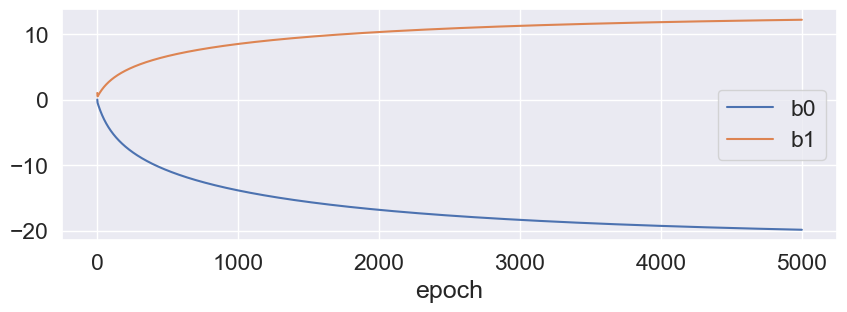

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10, 3))
ax.plot(trace[:, 0], label="b0")
ax.plot(trace[:, 1], label="b1")
ax.legend();
ax.set_xlabel("epoch");

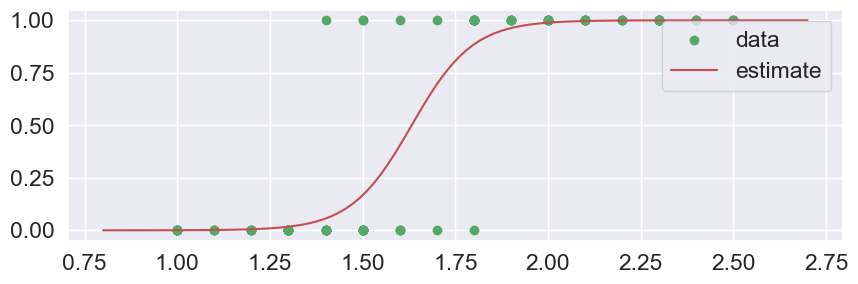

In [19]:
xs = np.linspace(0.8, 2.7, 100)
rs = linear_predictor(xs, b0=b0, b1=b1)
ps = prob(rs)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.scatter(X, Y, color=c_list[2], label="data")
ax.plot(xs, ps, color=c_list[3], label="estimate")
ax.legend();

## 問題設定3: アヤメデータセット(多変量)


### モデル設計

先のデータ確認の図から、単変量でもそこそこの分離ができそうだが、petal_length, petal_widthの二変数を利用するとさらに分離精度が上がりそう。2次の線形予測子によるロジスティック回帰モデルを仮定する。

- 目的変数$y_i$: virginicaであるか否か
    - $y_i \sim \mathrm{Bern}\left( y_i | p_i \right)$
- $y_i$の生起確率: $p_i = \mathrm{Sigmoid}(r_i) = \frac{1}{1 + \exp(-r_i)}$
- 線形予測子: $r_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}$
    - 説明変数$x_i$は１種類(petal_length)

このモデルにおける未知のパラメータは線形予測子の係数($\beta_0, \beta_1, \beta_2$)の三つ。

In [20]:
def linear_predictor(x1, x2, b0, b1, b2):
    return (b0 + b1*x1 + b2*x2)

def prob(r):
    return (1. / (1. + np.exp(-1. * r)))

### パラメータ推定(勾配法)

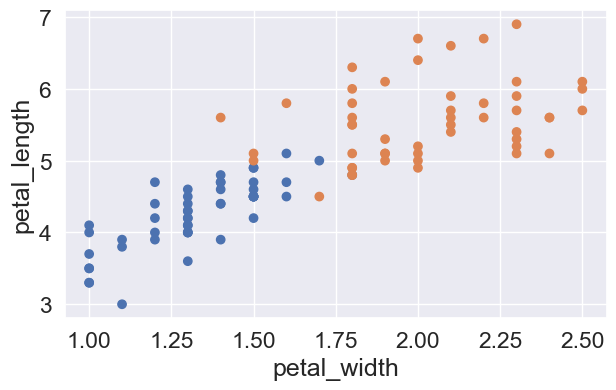

In [21]:
Y = [int(s == "virginica") for s in df.species]
X1 = df.petal_width.values
X2 = df.petal_length.values

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
cs = [c_list[i] for i in Y]
ax.scatter(X1, X2, color=cs)
ax.set_xlabel("petal_width");
ax.set_ylabel("petal_length");

In [22]:
# 初期値
b0, b1, b2 = 0.0, 1.0, 1.0

# 学習係数
alpha = 0.01

epoch = 50000  # 繰り返し回数(epoch数)
trace = [[b0, b1, b2]]
for i in range(epoch):
    rs = linear_predictor(X1, X2, b0, b1, b2)
    ps = prob(rs)
    b0 = b0 + alpha * np.sum(Y - ps)
    b1 = b1 + alpha * np.sum((Y - ps)*X1)
    b2 = b2 + alpha * np.sum((Y - ps)*X2)
    trace.append([b0, b1, b2])
trace = np.array(trace)

print(f"(b0, b1, b2) = ({b0: 2.3}, {b1: 2.3}, {b2: 2.3})")

(b0, b1, b2) = (-44.3,  10.3,  5.61)


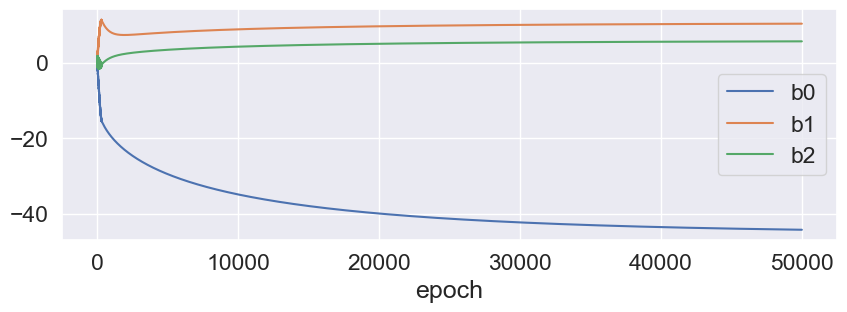

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10, 3))
ax.plot(trace[:, 0], label="b0")
ax.plot(trace[:, 1], label="b1")
ax.plot(trace[:, 2], label="b2")
ax.legend();
ax.set_xlabel("epoch");

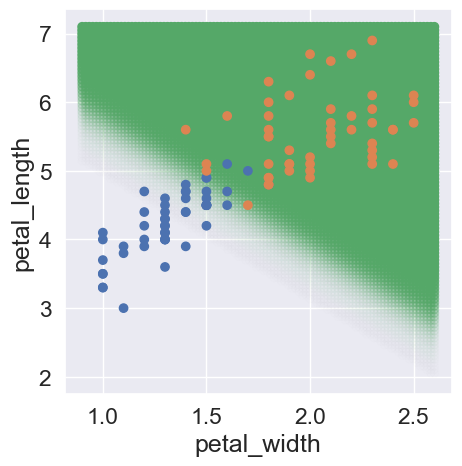

In [24]:
x1 = np.linspace(0.9, 2.6, 100)
x2 = np.linspace(2.0, 7.1, 100)
xx1, xx2 = np.meshgrid(x1, x2)

p_lst = []
for _xx, _yy in zip(xx1.ravel(), xx2.ravel()):
    r = linear_predictor(_xx, _yy, b0, b1, b2)
    p_lst.append(prob(r))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(xx1.ravel(), xx2.ravel(), color=c_list[2], alpha=p_lst)
ax.scatter(X1, X2, color=cs)
ax.set_xlabel("petal_width");
ax.set_ylabel("petal_length");